<a href="https://colab.research.google.com/github/ekunnii/ift6135-submission/blob/master/assignment1/Cats_Dogs_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/My\ Drive/ift6135/assignment1/all.zip


Archive:  /content/gdrive/My Drive/ift6135/assignment1/all.zip
  inflating: testset.zip             
  inflating: sample_submission.csv   
  inflating: trainset.zip            


In [3]:
!unzip testset.zip
!unzip trainset.zip

Archive:  testset.zip
   creating: testset/
   creating: testset/test/
  inflating: testset/test/63.jpg     
  inflating: testset/test/823.jpg    
  inflating: testset/test/4217.jpg   
  inflating: testset/test/3578.jpg   
  inflating: testset/test/2666.jpg   
  inflating: testset/test/2100.jpg   
  inflating: testset/test/4571.jpg   
  inflating: testset/test/1409.jpg   
  inflating: testset/test/189.jpg    
  inflating: testset/test/2114.jpg   
  inflating: testset/test/4565.jpg   
  inflating: testset/test/4203.jpg   
  inflating: testset/test/2672.jpg   
  inflating: testset/test/77.jpg     
  inflating: testset/test/837.jpg    
  inflating: testset/test/2882.jpg   
  inflating: testset/test/3544.jpg   
  inflating: testset/test/1353.jpg   
  inflating: testset/test/1435.jpg   
  inflating: testset/test/3222.jpg   
  inflating: testset/test/2128.jpg   
  inflating: testset/test/3236.jpg   
  inflating: testset/test/4559.jpg   
  inflating: testset/test/1421.jpg   
  inflating: test

In [4]:
# follow the instruction of below blog on medium
# https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

# Organizing data
import os.path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import csv
import time


# Set the env
PATH = "/content/"
CAT_DIR = f'{PATH}trainset/Cat/'
DOG_DIR = f'{PATH}trainset/Dog/'
TRAIN_DIR = f'{PATH}trainset/'
TEST_DIR = f'{PATH}/testset/'

PERMANENT_PATH = '/content/gdrive/My Drive/ift6135/assignment1/'
CHECK_POINT_FILE = f'{PERMANENT_PATH}dogs_cats_checkpoint.tar'
SUBMISSION_FILE = f'{PERMANENT_PATH}submission.csv'
MODEL_FILE = f'{PERMANENT_PATH}model/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Data augmentation and validation
# For training image,rotation, flip and resize are applied
# The ratio comes from below link
# https://discuss.pytorch.org/t/whats-the-range-of-the-input-value-desired-to-use-pretrained-resnet152-and-vgg19/1683

data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            224, scale=(0.96, 1.0), ratio=(1.05, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.RandomResizedCrop(
            224, scale=(0.96, 1.0), ratio=(1.05, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


full_train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR, transform=data_transforms['train'])

#Split train dataset into 19000 to train and the rest is to valid
train_size = int(0.95 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
print(train_size, valid_size)
train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = ('Cat', 'Dog')

print("train data size %i" % len(train_dataset))



18998 1000
train data size 18998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])


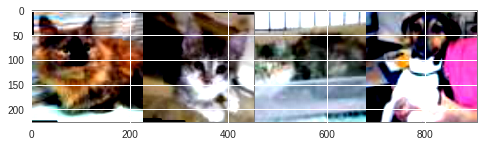

Ground Truth:    Cat   Cat   Cat   Dog


In [6]:

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(images.size())

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' %
                                 classes[labels[j]] for j in range(4)))

In [0]:
def train_model(net, criterion, optimizer, epoch_num):

    # variables tracking the error rates
    train_correction_rate = []
    valid_correction_rate = []
    train_loss = []
    valid_loss = []

    # train the network
    for epoch in range (epoch_num): 

        running_loss = 0.0
        start_time = time.time()
        
        for i, data in enumerate(train_dataloader, 0):

            # get the inputs
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
            
        print ("Epoch ", epoch+1, "Finished training. Calculating correction rate on valid set...")
        print("Correction rate on training dataset")
        train_correction_rate_ = test_on_validation(net, train_dataloader, print_acc=True)
        print("Correction rate on validation dataset")
        valid_correction_rate_ = test_on_validation(net, valid_dataloader, print_acc=True)
        train_correction_rate.append(train_correction_rate_)
        valid_correction_rate.append(valid_correction_rate_)
        
        # save the model every 10 epoch
        if epoch % 10 == 9:
          print("Saving the trained model every 10 epoch")
          torch.save({
              'epoch': epoch,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss
              }, f'{PATH}/checkpoint.tar')
        
    stop_time = time.time()
    print("Training finished.Training time in total", (stop_time- start_time))
    
    return (train_correction_rate, valid_correction_rate)

def test_on_validation(net, dataloader, print_acc=True):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    class_correct_rate = list(0. for i in range(len(classes)))

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)    #Pylint shows an error here, but it's working
            c = (predicted == labels)
            for i in range(len(data)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):

        if class_total[i] == 0:
            class_correct_rate[i] = 0
        else:
            class_correct_rate[i] = class_correct[i] / class_total[i]
        if print_acc == True:
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct_rate[i]))

    overall_correct_rate = sum(class_correct) / sum(class_total)

    return overall_correct_rate

#Network 1, simple and basic

In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Network 2, VGG16

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv7 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv8 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv9 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv10 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv11 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv12 = nn.Conv2d(512, 512, 3, 1, 1)
        self.fc1 = nn.Linear(512 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool(x)
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool(x)
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Network  3, reduced VGG16

In [0]:
class Net3(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc1 = nn.Linear(256*56*56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = x.view(-1, 256*56*56)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [0]:
# spawn the network
net = Net()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

(train_correction_rate, valid_correction_rate) = train_model(net, criterion, optimizer, epoch_num=20)

[1,  1000] loss: 0.684
[1,  2000] loss: 0.673
[1,  3000] loss: 0.669
[1,  4000] loss: 0.661
Epoch  1 Finished training. Calculating correction rate on valid set...
Correction rate on training dataset
Accuracy of   Cat : 64 %
Accuracy of   Dog : 61 %
Correction rate on validation dataset
Accuracy of   Cat : 64 %
Accuracy of   Dog : 65 %
[2,  1000] loss: 0.644
[2,  2000] loss: 0.640
[2,  3000] loss: 0.637
[2,  4000] loss: 0.625
Epoch  2 Finished training. Calculating correction rate on valid set...
Correction rate on training dataset
Accuracy of   Cat : 85 %
Accuracy of   Dog : 44 %
Correction rate on validation dataset
Accuracy of   Cat : 85 %
Accuracy of   Dog : 48 %
[3,  1000] loss: 0.613
[3,  2000] loss: 0.602
[3,  3000] loss: 0.587
[3,  4000] loss: 0.590
Epoch  3 Finished training. Calculating correction rate on valid set...
Correction rate on training dataset
Accuracy of   Cat : 78 %
Accuracy of   Dog : 61 %
Correction rate on validation dataset
Accuracy of   Cat : 75 %
Accuracy of

NameError: ignored

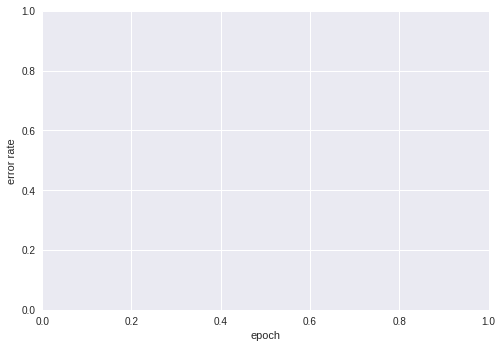

In [11]:
train_error_rate = []
valid_error_rate = []
for i in range(len(train_correction_rate)):
    train_error_rate.append(1 - train_correction_rate[i])
    valid_error_rate.append(1 - valid_correction_rate[i])

np.save("problem3_train_error", np.array(train_error_rate))
np.save("problem3_valid_error", np.array(valid_error_rate))

#%%
plt.figure()
plt.xlabel("epoch")
plt.ylabel("error rate")
plt.plot(range(len(valid_error_rate)), train_error_rate)
plt.plot(range(len(valid_error_rate)), valid_error_rate)
plt.grid()
plt.legend(('train error rate', 'validation error rate'))
plt.show()

In [9]:
from torchsummary import summary
summary(net.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 128, 112, 112]         147,584
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Linear-8                  [-1, 120]      96,338,040
            Linear-9                   [-1, 84]          10,164
           Linear-10                    [-1, 2]             170
Total params: 96,903,702
Trainable params: 96,903,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 88.81
Params size (MB): 369.66
Es

In [0]:
import numbers
import torchvision

# https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/7
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))
        kernel = torch.Tensor(kernel).to(device)

        self.register_buffer('weight', kernel)
        self.groups = channels

        self.conv = F.conv2d

    def forward(self, img):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(img, weight=self.weight, groups=self.groups)


def gradient_ascent(model, img, n_times, label):
    """ 
    Gradient ascent on the images to find the image 
    that maximize the score of a given class. Hyperparameters
    for weight decay / GaussianBlur from (Yosinski & al. 2015)
    Arguments:
            img (torch.Tensor): Image to do gradient ascent on.
            n_times (int): # of iterations of gradient ascent steps
            label (string): 'Cat' or 'Dog'
        Returns:
            img (torch.Tensor): Image that maximizes the score.
       
    """
    model.eval()
    step_size = 3
    
    n_classes = 2
    y = (torch.LongTensor(1,1).to(device)).random_() % n_classes
    y_onehot = torch.FloatTensor(1, n_classes).to(device)
           
    if label == 'Cat':
        y[0] = 0       
    else:
        y[0] = 1
    
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1) 
    
    for i in range(n_times):
      
      if i % 50 == 0:
        step_size /= 2

      if i % 4 == 0 and i > 0:
        # Gaussian blur
        img = F.pad(img, (2, 2, 2, 2), mode='reflect')
        img = smoothing(img)
      
      
      model.zero_grad()
          
      output = model(img)
      
      # with L2 regularization
      loss = output[0, y[0]] - 0.0001 * img.data.norm()
      
      if i % 20 == 0:
        print('%s : loss = %.4f' % (label, loss))
      grad = torch.autograd.grad(loss, img, 
                                 grad_outputs=y_onehot)
                 
      grad = grad[0].data
      img += step_size * grad 
      img = torch.clamp(img, 0., 1.)

      
    img = torch.clamp(img, 0., 1.)
    return img

  

# Load your trained model here
model_vis = VGGNet().to(device)
model_vis.load_state_dict(torch.load(added_path + 'model_89_vgg_net_3fc.pth'))
model_vis.eval()  

# Sigma is the std_dev of the Gaussian kernel 
# --> the higher, the more "smooth" the image will be
# Here we are using hyperparamers from (Yosinski & al. 2015).
smoothing = GaussianSmoothing(3, kernel_size=5, sigma=1)

n_iter = 100
    
fake_img_size = [64, 64]

# Find the image that maximizes the score of the cat class
img_cat = torch.zeros(1, 3, fake_img_size[0], fake_img_size[1], 
                      requires_grad=True).to(device)

img_cat = gradient_ascent(model_vis, img_cat, n_iter, 'Cat')

torchvision.utils.save_image(img_cat , added_path + 'img_cat.png')
img_to_show = img_cat.view(3, fake_img_size[0], fake_img_size[1]).detach().cpu()
print_one_image(img_to_show, 'Cat')

# Find the image that maximizes the score of the dog
img_dog = torch.zeros(1, 3, fake_img_size[0], fake_img_size[1], 
                      requires_grad=True).to(device)   


img_dog = gradient_ascent(model_vis, img_dog, n_iter, 'Dog')
torchvision.utils.save_image(img_dog , added_path + 'img_dog.png')
img_to_show_dog = img_dog.view(3, fake_img_size[0], fake_img_size[1]).detach().cpu()
print_one_image(img_to_show_dog, 'Dog')

In [0]:
!cp checkpoint.tar /content/gdrive/My\ Drive/ift6135/assignment1/model

In [0]:
checkpoint = torch.load(f'{PATH}/checkpoint.tar')

net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

net.eval()
# - or -
#model.train()


In [0]:
class ImageFolderWithPath(datasets.ImageFolder):
    """Custom dataset that include image file paths.
    Extends torchvision.datasets.ImageFolder
    """

    # Overrider the __getitem__ method.
    def __getitem__(self, index):
        # This is the return of original ImageFolder
        orig_tuple = super(ImageFolderWithPath, self).__getitem__(index)
        # Get the image file path
        path = self.imgs[index][0]
        # Make a new tuple that includes original returns and path
        tuple_with_path = (orig_tuple + (path,))
        return tuple_with_path


test_datasets = ImageFolderWithPath(
    root=TEST_DIR, transform=data_transforms['test'])
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_datasets, batch_size=4, shuffle=False, num_workers=2
)

In [0]:
results = {}

for images, labels, paths in test_dataloader:
  paths = list(paths)
  index = []
  
  for i in range(len(paths)):
    head, tail = os.path.split(paths[i])
    index.append(os.path.splitext(tail)[0])

  # OK, Let's see what neural network think these examples are
  images = images.to(device)
  outputs = net(images)
  
  # the outputs are energies for the 10 classes.

  _, predicted = torch.max(outputs, -1)
  predicted=predicted.data.cpu().numpy().tolist()
  
  for i, j  in zip(index, predicted):
    results[i] = classes[j]

In [0]:
import pandas as pd

df = pd.DataFrame.from_dict(results, orient='index')
df.index = df.index.map(int)
df = df.sort_index()
df.columns = ['label']
df['id'] = df.index

df = df[['id', 'label']]
df.head()

In [0]:
df.to_csv('submission.csv', index = False)
!head -10 submission.csv

In [0]:
!cp submission.csv /content/gdrive/My\ Drive/ift6135/assignment1/